In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab12.ipynb")

# Lab 12: Climate data, CO2 and xarray

## Due Date

This assignment is due on **Wednesday November 17th, 2021, at 11:59PM PDT**.

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your solution.

This lab accompanies a lecture for Berkeley's Data 100 that covers the fundamental physical mechanisms behind global warming and analyzes CO2 and ocean temperature data.

Authors: Fernando Pérez and [Dr. Chelle Gentemann](https://cgentemann.github.io).

**Collaborators:** *list names here*

In [2]:
# Run this cell to set up your notebook
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


## Loading the Mauna Loa CO2 data

We start by loading the same dataset we used during the lecture, containing CO2 measurements in Mauna Loa, Hawaii.

In [3]:
# Set up to load data either from the shared directory that has the complete set,
# or from the local small copy available in the repo

DATA_DIR = Path('./data')

# If you want to run this on the Berkeley data hub, where we have a larger version of the data,
# uncomment the below. But do not do that for submitting the Lab, as the version that will
# run on the grader needs to use the path above and only has enough data to grade the Lab.
#DATA_DIR = Path.home()/Path('shared/climate-data')

Now we start by loading the CO2 data from a CSV file:

In [4]:
co2_file = DATA_DIR / "monthly_in_situ_co2_mlo_cleaned.csv"
data = pd.read_csv(co2_file)
data.head()

,year,month,date_index,fraction_date,c02,data_adjusted_season,data_fit,data_adjusted_seasonally_fit,data_filled,data_adjusted_seasonally_filed
0,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
2,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.98,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71


In [5]:
# get rid of missing values that are set to -99.99 and then drop from the dataset
data = pd.read_csv(co2_file, na_values=-99.99).dropna()
data.head()

,year,month,date_index,fraction_date,c02,data_adjusted_season,data_fit,data_adjusted_seasonally_fit,data_filled,data_adjusted_seasonally_filed
2,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.98,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71
6,1958,7,21381,1958.5370,315.86,315.19,315.86,315.22,315.86,315.19
7,1958,8,21412,1958.6219,314.93,316.19,313.99,315.29,314.93,316.19


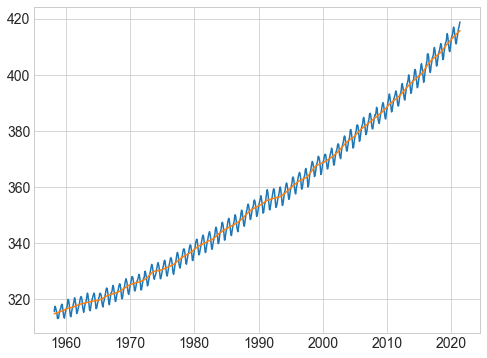

In [6]:
# We did this in lecture, as a reminder this is what the data looks like:
plt.plot("fraction_date", "c02", data=data)
plt.plot("fraction_date", "data_adjusted_seasonally_fit", data=data);

# Exploring the annual anomaly

We are going to try to understand the annual variability on top of the growing trend, and see whether that variability is itself changing over time or not.

The figure above shows an annual cycle, alongside with perhaps some variability in it. As we saw in lecture (recall the super computer movie in talk with cities release of co2 strongest in winter), plants take up CO2 in (northern) spring/summer then release in fall/winter --- so the release is getting stronger. 

Let's try to estimate the increase in amplitude of annual cycle.

<!-- why would using a rolling mean make it look like the cycle is getting larger - both summer/winter rather than just winter? with this data can you figure out if summer or winter causing increase? -->

In the lecture notebook, we created the following figure, based on a quick and simple groupby operation and removal of the annual mean:

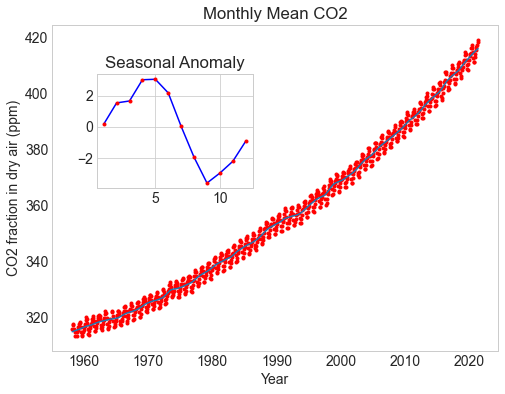

In [7]:
# calculate the annual cycle using groupby
annual = data.groupby(data.month).mean()
# calculate the anomaly
anomaly = annual - annual.mean()

# plot
fig, ax = plt.subplots()

ax.plot("fraction_date", "data_filled", "r.", data=data)
ax.plot("fraction_date", "data_adjusted_seasonally_fit", data=data)
ax.set_xlabel("Year")
ax.set_ylabel("CO2 fraction in dry air (ppm)")
ax.set_title("Monthly Mean CO2")
ax.grid(False)

axin1 = ax.inset_axes([0.1, 0.5, 0.35, 0.35])
axin1.plot(anomaly.c02, "b")
axin1.plot(anomaly.c02, "r.")
axin1.set_title("Seasonal Anomaly");

But if you look closely, that figure isn't quite the same as the one shown in slide 9 of the lecture:

<img src="annual-anomaly-orig.png" width="700px" />

We'll start by trying to understand the monthly data. The following shows us the data for all the years, by month:

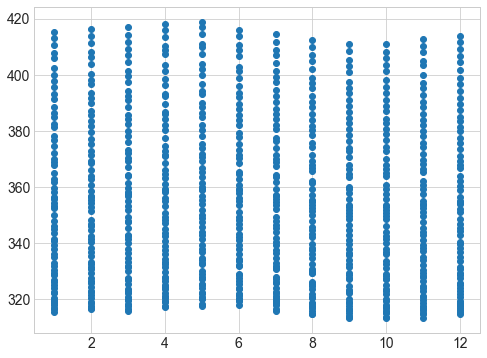

In [8]:
plt.scatter('month', 'c02', data=data);

Unfortunately it's hard to see what's actually going on here.

### Question 1

Recreate the following figure, that shows the monthly cycle for all the years in the dataset:

<img src="monthly-cycles-co2.png" width="700px" />

Hint: Use `sns.lineplot(...)`

<!--
BEGIN QUESTION
name: q1
-->

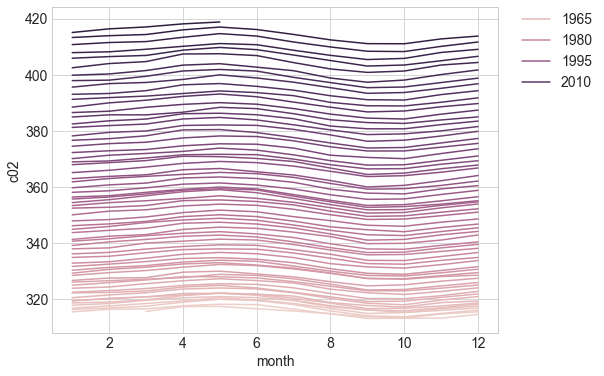

In [9]:
sns.lineplot(data=data, x='month', y='c02', hue='year')
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0); 

### Question 2

Next, in order to recreate the figure in the talk, we're going to find the monthly anomaly averaging across years. You should end up with the following data frame after writing your function and running the cell (only the first few months are shown, it should have data for all 12 months):

<img src="monthly-co2-anomaly-df.png" width="150px" />

<!--
BEGIN QUESTION
name: q2
-->

In [10]:
def detrend(f):
    detrended_xarr = f - np.mean(f, axis=0)
    detrended_xarr['month'] = f['month']
    return detrended_xarr

dy = data.groupby('year')
c02anomaly = dy.apply(detrend)
display(c02anomaly)
monthly_anomaly = c02anomaly.groupby('month').mean()[['c02']]
monthly_anomaly

,year,month,date_index,fraction_date,c02,data_adjusted_season,data_fit,data_adjusted_seasonally_fit,data_filled,data_adjusted_seasonally_filed
2,0.0,3,-133.875,-0.366825,0.3675,-0.870,0.9375,-0.32125,0.3675,-0.870
3,0.0,4,-102.875,-0.281825,2.1175,-0.140,2.0475,-0.24125,2.1175,-0.140
4,0.0,5,-72.875,-0.199625,2.1775,-0.590,2.6075,-0.16125,2.1775,-0.590
6,0.0,7,-11.875,-0.032525,0.5275,-0.110,0.6075,-0.00125,0.5275,-0.110
7,0.0,8,19.125,0.052375,-0.4025,0.890,-1.2625,0.06875,-0.4025,0.890
...,...,...,...,...,...,...,...,...,...,...
756,0.0,1,-60.000,-0.164380,-2.0180,-0.358,-1.9880,-0.32800,-2.0180,-0.358
757,0.0,2,-29.000,-0.079480,-0.7180,0.232,-1.0980,-0.14800,-0.7180,0.232
758,0.0,3,-1.000,-0.002780,-0.0480,0.122,-0.1680,0.00200,-0.0480,0.122
759,0.0,4,30.000,0.082220,1.0520,-0.028,1.2520,0.16200,1.0520,-0.028


,c02
month,
1,-0.683835
2,0.076121
3,0.874238
4,2.240270
5,2.864155
6,2.299297
7,0.792919
8,-1.195018
9,-2.851367


🤔 **It says this is not corrent. However, we can find that it is the precision error of the floating point number**

In [11]:
grader.check("q2")

q2 results:
    q2 - 1 result:
        Trying:
            list(monthly_anomaly['c02']) == [-0.6838350970017644, 0.07612096774193428, 0.8742380952380925,
                                             2.240269841269833, 2.8641545138888853, 2.299296594982075, 
                                             0.792918871252205, -1.1950176366843068, -2.851366843033514, 
                                             -2.8573163082437323, -1.453271604938272, -0.15930335097002282]
        Expecting:
            True
        **********************************************************************
        Line 1, in q2 0
        Failed example:
            list(monthly_anomaly['c02']) == [-0.6838350970017644, 0.07612096774193428, 0.8742380952380925,
                                             2.240269841269833, 2.8641545138888853, 2.299296594982075, 
                                             0.792918871252205, -1.1950176366843068, -2.851366843033514, 
                                             -2.8573163082437323, -1.453271604938272, -0.15930335097002282]
        Expected:
            True
        Got:
            False

### Question 3

Next, recreate the following figure, which is much closer to the one in the lecture:

<img src="annual-anomaly-new.png" width="700px" />

**Hints:** 
- in order to get that smooth curve, you'll need to use `from scipy.interpolate import CubicSpline`. You can find the documentation for `CubicSpline` [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html).
- The "Seasonal Anomaly" inset graph can be created with `ax.inset_axes(...)`. You can treat the `Axes` object returned like any other `Axes` object.
- Remember that you can set the tick labels with `ax.set_xticks(...)`.
- To get the data points plotted as red dots, when you use `ax.plot(...)`, pass in `"r."` as the argument immediately following any data you pass in. The `"r"` indicates the color, while the `"."` indicates how the data will be plotted (if you don't put the `"."`, it will be a line instead).

<!--
BEGIN QUESTION
name: q3
-->

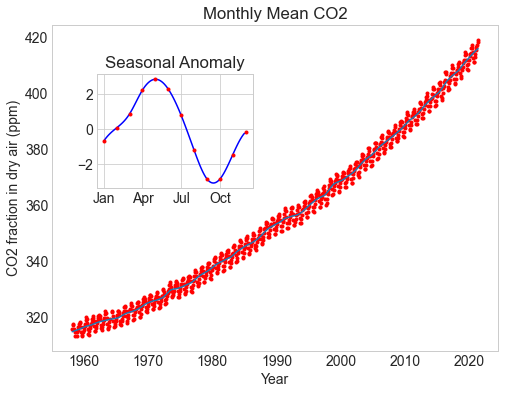

In [12]:
from scipy.interpolate import CubicSpline

# plot
fig, ax = plt.subplots()


ax.plot("fraction_date", "data_filled", "r.", data=data)
ax.plot("fraction_date", "data_adjusted_seasonally_fit", data=data)
ax.set_xlabel("Year")
ax.set_ylabel("CO2 fraction in dry air (ppm)")
ax.set_title("Monthly Mean CO2")
ax.grid(False)

axin1 = ax.inset_axes([0.1, 0.5, 0.35, 0.35])
x, y = monthly_anomaly.index, monthly_anomaly['c02']
cs = CubicSpline(x, y)
xs = np.arange(1, 12, 0.1)
axin1.plot(xs, cs(xs), 'b')
axin1.plot(monthly_anomaly.c02, "r.")
axin1.set_title("Seasonal Anomaly")
axin1.set_xticks([1,4,7,10])
axin1.set_xticklabels(['Jan', 'Apr','Jul','Oct']);

# Exploring Snow with ERA 5

Now, we turn our attention to the global ERA 5 dataset and explore some other questions - it's a very rich and interesting dataset, and the lecture only scratched its surfac!

We are going today to focus on just one more bit: we'll take a look at the snow accumulation data for the northern and southern hemispheres.

But you should see this as an invitation to keep learning from these data! Think of looking at other variables in the dataset. Is there annual cycle? trend? Some of the data might look very different than the air temperature - eg. precipitation which is either 0 or +. Can you use PDFs to look at changes in distributions over a region? at a point? Or talk about the data a little & what you understand it is measuring? Are any of the data variables related to each other? Can you plot correlations between data?

In [13]:
import xarray as xr

monthly_2deg_path = DATA_DIR / "era5_snow_monthly_2deg_aws_v20210920.nc"

# The Berkeely hub has a version with not only snow data but many more variables.
# You can explore the full dataset by uncommenting the following  if you are on the
# campus hub. Do NOT do that for your lab submission, as that data is NOT available
# on Gradescope.
# monthly_2deg_path = DATA_DIR / "era5_monthly_2deg_aws_v20210920.nc"

ds = xr.open_dataset(monthly_2deg_path)
ds

/usr/local/Caskroom/miniconda/base/envs/mixed/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/mixed/lib/python3.9/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:       (time: 504, latitude: 90, longitude: 180)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-16T11:30:00 ... 2020-12-16T11...
  * latitude      (latitude) float32 -88.88 -86.88 -84.88 ... 85.12 87.12 89.12
  * longitude     (longitude) float32 0.875 2.875 4.875 ... 354.9 356.9 358.9
Data variables:
    snow_density  (time, latitude, longitude) float32 ...

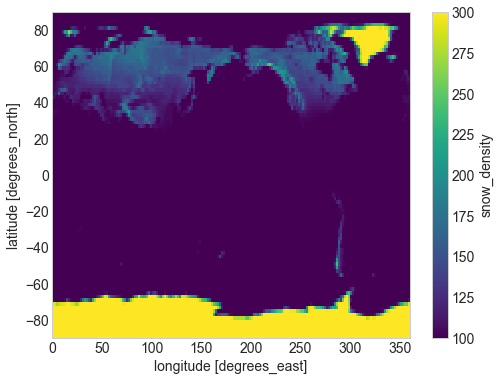

In [14]:
mean_map = ds.mean("time")  # takes the mean across all variables in ds
mean_map.snow_density.plot();

In [15]:
snow = ds.snow_density
snow

<xarray.DataArray 'snow_density' (time: 504, latitude: 90, longitude: 180)>
array([[[300., 300., ..., 300., 300.],
        [300., 300., ..., 300., 300.],
        ...,
        [100., 100., ..., 100., 100.],
        [100., 100., ..., 100., 100.]],

       [[300., 300., ..., 300., 300.],
        [300., 300., ..., 300., 300.],
        ...,
        [100., 100., ..., 100., 100.],
        [100., 100., ..., 100., 100.]],

       ...,

       [[300., 300., ..., 300., 300.],
        [300., 300., ..., 300., 300.],
        ...,
        [100., 100., ..., 100., 100.],
        [100., 100., ..., 100., 100.]],

       [[300., 300., ..., 300., 300.],
        [300., 300., ..., 300., 300.],
        ...,
        [100., 100., ..., 100., 100.],
        [100., 100., ..., 100., 100.]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-16T11:30:00 ... 2020-12-16T11:30:00
  * latitude   (latitude) float32 -88.88 -86.88 -84.88 ... 85.12 87.12 89.12
  * longitude  (longitude) float32 0.875 2.875 4.875 6.875 ... 354.9 356.9 358.9
Attributes:
    long_name:       Snow density
    nameCDM:         Snow_density_surface
    nameECMWF:       Snow density
    product_type:    analysis
    shortNameECMWF:  rsn
    standard_name:   snow_density
    units:           kg m**-3

### Question 4

Let's look at the snow across the globe in February and August, which are roughly the peaks of the summer/winter seasons.

Recreate the following figure, along with a corresponding one for August 1980:

<img src="snow-distribution-1980-02.png" width="500px" />

<!--
BEGIN QUESTION
name: q4
-->

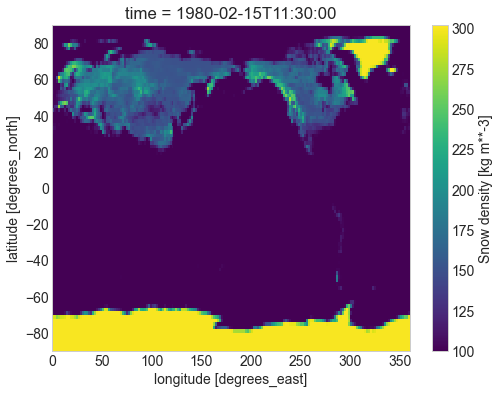

In [16]:
snow.sel(time='1980-02-15T11:30:00').plot();

### Question 5

Let's now find the peaks in the northern and southern hemispheres.

<!--
BEGIN QUESTION
name: q5
-->

In [17]:
min(snow.latitude), max(snow.latitude)

(<xarray.DataArray 'latitude' ()>
 array(-88.875, dtype=float32)
 Coordinates:
     latitude  float32 -88.88
 Attributes:
     long_name:      latitude
     standard_name:  latitude
     units:          degrees_north,
 <xarray.DataArray 'latitude' ()>
 array(89.125, dtype=float32)
 Coordinates:
     latitude  float32 89.12
 Attributes:
     long_name:      latitude
     standard_name:  latitude
     units:          degrees_north)

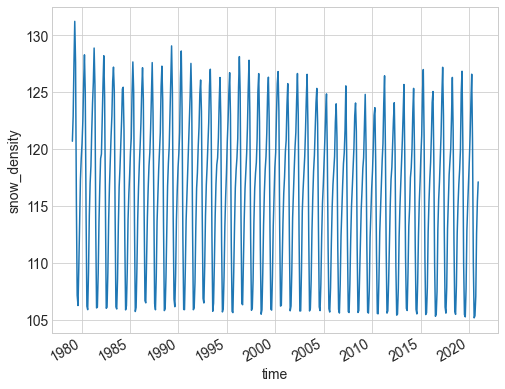

In [18]:
t_snow_north = snow.sel(latitude=slice(0, 90)).mean(['latitude', 'longitude'])
t_snow_north.plot();

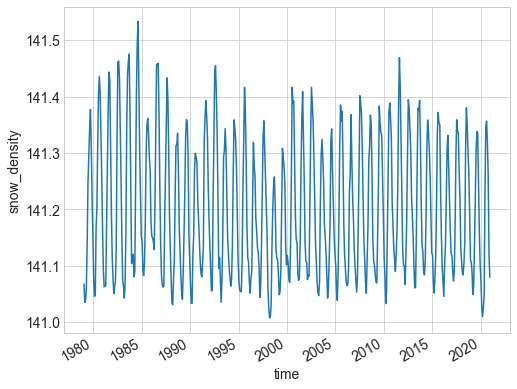

In [19]:
t_snow_south = snow.sel(latitude=slice(-90, 0)).mean(['latitude', 'longitude'])
t_snow_south.plot();

### Question 6

Let's look for example at what the cycle in the northern hemisphere looks like for the year 1979. You need to replicate this figure:

<img src="snow-cycle-1979.png" width="500px" />

<!--
BEGIN QUESTION
name: q6
-->

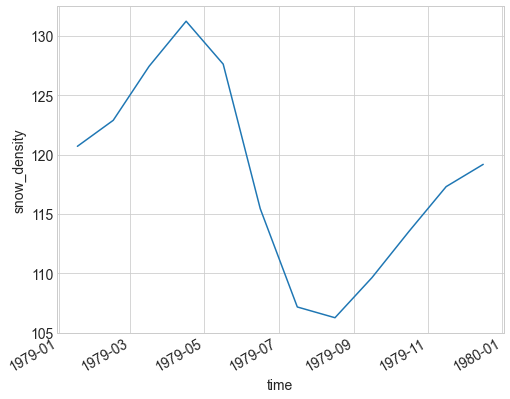

In [20]:
t_snow_north.isel(time=slice(12)).plot()

### Question 7

And finally, we're going to find the peaks for the maximum and minimum snow accumulation in both hemispheres, and study when those peaks happen, how much snow there is, and whether the amounto of total snow is going up or down.

You'll need to recreate a dataframe like the one pictured here (only a few rows shown, and this is for the northern hemisphere, you'll make one for each hemisphere):

<img src="snow-peaks-north-df.png" width="900px" />

**Hint:** look up the documentation for the xarray `idxmax` method.

**Hint:**
1. First, we want to extract the years from the data and iterate over them (try using `range`).
1. When iterating over the years, we want to first pick the designated year, then find the days with the most and least snow as well as the amount of snow on those days.
1. Once we've found the days, assign `vals` to be an array of the information we've calculated.
1. Finally, append all the necessary information to `peaks`.

- Amplitude is `max - min`
- You may want to use `x.values.item` to extract information from the datetime objects.

<!--
BEGIN QUESTION
name: q7
-->

In [21]:
qq = pd.to_datetime(t_snow_north.sel(time='1979').idxmax().dt.strftime("%Y-%m-%d %H:%M:%S").item())
int(qq.strftime('%j'))

105

In [22]:
def extract_peaks(snow_data):
    # extract years
    years = list(set(snow.time.dt.year.data.tolist()))
    years = [str(year) for year in years]
    peaks = []
    for y in years:
        thisyear = snow_data.sel(time=y)
        min_date = pd.to_datetime(thisyear.idxmin().dt.strftime("%Y-%m-%d %H:%M:%S").item())
        max_date = pd.to_datetime(thisyear.idxmax().dt.strftime("%Y-%m-%d %H:%M:%S").item())
        
        min_snow = thisyear.min().data.item()
        max_snow = thisyear.max().data.item()
        vals = [y, str(min_date), str(max_date), 
                int(min_date.strftime('%j')),
                int(max_date.strftime('%j')),
                min_snow, max_snow,
                max_snow - min_snow]
        peaks.append(vals)

    snow_peaks = pd.DataFrame(peaks, 
                              columns = ['year', 'min_date', 'max_date',
                                         'min_dayofyear', 'max_dayofyear',
                                         'min_snow', 'max_snow', 'amplitude'])

    return snow_peaks

peaks_north = extract_peaks(t_snow_north)
peaks_north.head()

,year,min_date,max_date,min_dayofyear,max_dayofyear,min_snow,max_snow,amplitude
0,1979,1979-08-16 11:30:00,1979-04-15 23:30:00,228,105,106.247375,131.242065,24.994690
1,1980,1980-08-16 11:30:00,1980-04-15 23:30:00,229,106,105.883469,128.295532,22.412064
2,1981,1981-07-16 11:30:00,1981-04-15 23:30:00,197,105,106.037796,128.892883,22.855087
3,1982,1982-07-16 11:30:00,1982-04-15 23:30:00,197,105,106.007599,128.216461,22.208862
4,1983,1983-08-16 11:30:00,1983-04-15 23:30:00,228,105,105.946030,127.215462,21.269432


With this data, we can now quickly explore several questions. For example, during what day of the year do the min and max happen?

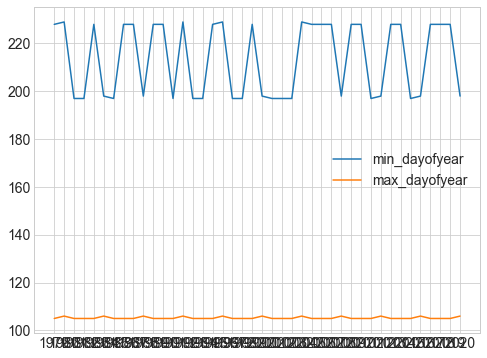

In [23]:
plt.plot('year', 'min_dayofyear', data=peaks_north);
plt.plot('year', 'max_dayofyear', data=peaks_north);
plt.legend();

What is the min and max amount of snow at those times?

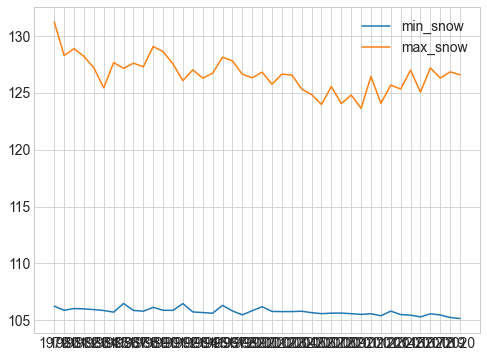

In [24]:
plt.plot('year', 'min_snow', data=peaks_north);
plt.plot('year', 'max_snow', data=peaks_north);
plt.legend();

Given the difference in scales, it's a bit easier to see what is happening if we plot the min and max separately:

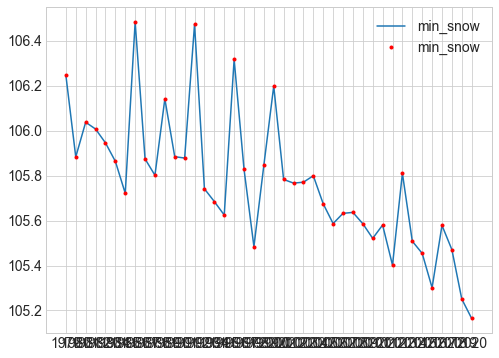

In [25]:
plt.plot('year', 'min_snow', data=peaks_north);
plt.plot('year', 'min_snow', 'r.', data=peaks_north);
plt.legend();

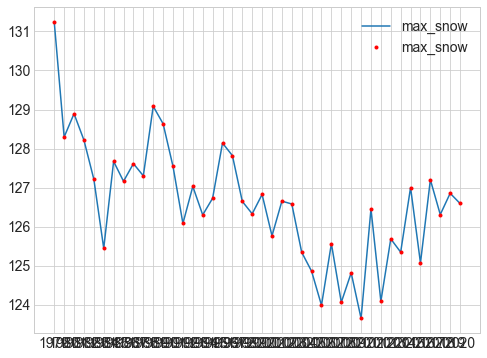

In [26]:
plt.plot('year', 'max_snow', data=peaks_north);
plt.plot('year', 'max_snow', 'r.', data=peaks_north);
plt.legend();

What do you think this is telling us about the ice in the northern hemisphere? What are the main sources of ice there, and what is happening to them?

The above figures are for the northern hemisphere. Repeat them for the southern one. What do you observe? Any differences?

I hope this lab has taught you some useful skills regarding tools like xarray and data with a different structure than data frames. But more importantly, that it has shown you how the ideas from this course also apply to problems as critical to humanity as climate change, and that you have the foundations on which to better understand these questions.

Don't stop here! This dataset is fascinating, and both the lecture and the lab were barely an appetizer!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [27]:
grader.check_all()

q2 results:
    q2 - 1 result:
        Trying:
            list(monthly_anomaly['c02']) == [-0.6838350970017644, 0.07612096774193428, 0.8742380952380925,
                                             2.240269841269833, 2.8641545138888853, 2.299296594982075, 
                                             0.792918871252205, -1.1950176366843068, -2.851366843033514, 
                                             -2.8573163082437323, -1.453271604938272, -0.15930335097002282]
        Expecting:
            True
        **********************************************************************
        Line 1, in q2 0
        Failed example:
            list(monthly_anomaly['c02']) == [-0.6838350970017644, 0.07612096774193428, 0.8742380952380925,
                                             2.240269841269833, 2.8641545138888853, 2.299296594982075, 
                                             0.792918871252205, -1.1950176366843068, -2.851366843033514, 
                                             -2.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [28]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)